In [6]:
from operators import BlockMatrixOperator, BlockTriangularPreconditioner
from tunnel_with_subdomains import load_matrices_from_hdf5, load_vectors_from_hdf5

problem_no = 1
path_to_data = f"exported_data_scaled/testrun_{problem_no}/"

# loading
A_blocks = load_matrices_from_hdf5(f"{path_to_data}data_as_blocks.h5")
Ptdiagblocks = load_matrices_from_hdf5(f"{path_to_data}data_diag_preco.h5")
Ptblocks = load_matrices_from_hdf5(f"{path_to_data}data_triang_preco.h5")
rhs_u, rhs_p = load_vectors_from_hdf5(f"{path_to_data}data_rhs.h5")  # each rhs_* is a list of ndarrays
sol_u, sol_p = load_vectors_from_hdf5(f"{path_to_data}data_sol.h5")  # each rhs_* is a list of ndarrays

In [7]:
import numpy as np
from numpy.linalg import norm
from scipy.sparse.linalg import gmres, LinearOperator

A_mat = BlockMatrixOperator(A_blocks)
Pt_inv = BlockTriangularPreconditioner(Ptblocks, False)
# Pt_inv = BlockTriangularPreconditioner(Ptdiagblocks, False)

# Define the preconditioned operator
A = LinearOperator(A_mat.shape, matvec=A_mat)
M = LinearOperator(Pt_inv.shape, matvec=Pt_inv)

In [9]:
iter_list = []
res_list = []
true_res_list = []
err_list = []
Z = None
Z_list = []
x_sol = None

warm_up = 10
maxit = 8

for index in range(10):  # max is 716
    rhs_vec = np.concatenate([rhs_u[index], rhs_p[index]])
    sol_vec = np.concatenate([sol_u[index], sol_p[index]])

    # Define a callback function to store residuals
    residuals = []
    def callback(resid):
        residuals.append(resid)

    if index > 0 and res_list[-1] < 1e-10:
        maxit -= 1
    # Solve the system using GMRES
    x_sol, info = gmres(A, rhs_vec, M=M, rtol=1e-10, maxiter=maxit, callback=callback, x0=x_sol)

    # Extract number of iterations (info > 0 indicates it stopped at maxit)
    num_iterations = len(residuals)

    iter_list.append(num_iterations)
    res_list.append(norm(M(A(x_sol) - rhs_vec)) / norm(rhs_vec))
    true_res_list.append(norm(M(A(sol_vec) - rhs_vec)) / norm(rhs_vec))
    err_list.append(norm(x_sol - sol_vec) / norm(sol_vec))
    print(f"Index {index}: {iter_list[-1]}, {res_list[-1]}, {err_list[-1]} {true_res_list[-1]}")

Index 0: 0, nan, nan nan
Index 1: 7, 2.496766991053056e-11, 2.968096043011368e-10 9.174900349484648e-10
Index 2: 7, 5.991827474706719e-12, 2.7941505799754465e-10 6.163830234642221e-10
Index 3: 6, 4.0603940914186974e-10, 4.0963980855339297e-10 4.507120149250578e-10
Index 4: 6, 3.151167807551976e-10, 4.525708101048041e-10 3.6340721076202475e-10
Index 5: 6, 2.5557489633759873e-10, 4.866500258274036e-10 3.189742239851046e-10
Index 6: 6, 2.1412631543629335e-10, 5.149533861108188e-10 2.983647800438246e-10
Index 7: 6, 1.838174807348284e-10, 4.300716302379895e-09 3.4050426084194157e-09
Index 8: 6, 1.6077455632043697e-10, 4.144615552281295e-09 2.9458177188770823e-09
Index 9: 6, 1.427115919486143e-10, 3.987003683116751e-09 2.586697827937388e-09


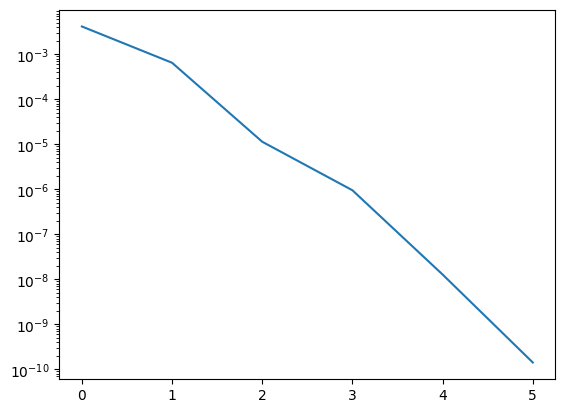

In [10]:
import matplotlib.pyplot as plt
plt.semilogy(residuals)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()